# Multi-GW FUOTA

This notebook simulates a network comprised of multiple EDs and GWs, in which the EDs employ Class C to receive an update from multiple GWs. DL transmissions are coordinated to limit the impact of Duty Cycle.

In [1]:
import sem
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from io import StringIO

In [2]:
ns_path = "../../../../"
script = "class-c-scaled-up"
results_folder = "class-c-testing"

campaign = sem.CampaignManager.new(ns_path,
                                   script,
                                   results_folder,
                                   overwrite=True,
                                   optimized=True,
                                   check_repo=False,
                                   max_parallel_processes=8)

Building ns-3: 100%|██████████| 1510/1510 [00:04<00:00, 20.59file/s]


In [3]:
print(campaign)

--- Campaign info ---
script: class-c-scaled-up
params: {'nGateways': 2.0, 'nDevices': 1.0, 'radius': 10000.0}
HEAD: 
Runner type: <class 'sem.parallelrunner.ParallelRunner'>
-----------


In [5]:
params = {
    'nGateways': [1, 2, 4],
    'nDevices': [1] + list(range(100, 400, 100)),
    'radius': [20000]
}
campaign.run_missing_simulations(params, runs=5)

Running simulations: 100%|██████████| 2/2 [01:41<00:00, 50.73s/simulation]


In [6]:
example_result = campaign.db.get_complete_results({'nGateways': 2})[0]

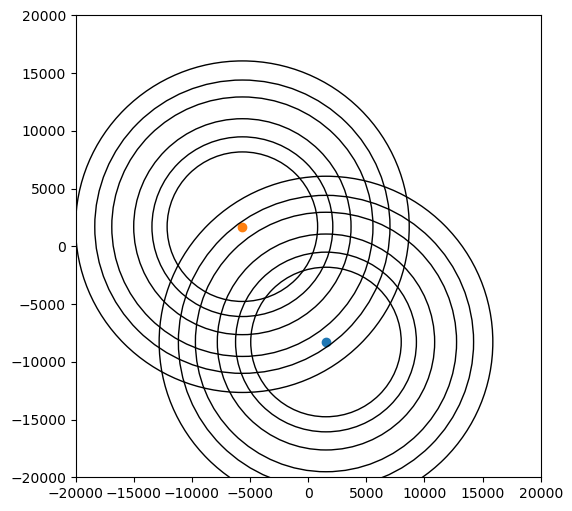

In [7]:
def plot_gateway_positions(result):
    plt.figure(figsize=[6, 6])
    gwpositions = np.loadtxt(StringIO(result['output']['gatewaypositions.txt']), delimiter=":")
    for gw in np.atleast_2d(gwpositions):
        plt.scatter(gw[0], gw[1])
        for line in result['output']['ranges.txt'].splitlines():
            circle = plt.Circle((gw[0], gw[1]), float(line), fill=False)
            plt.gca().add_patch(circle)
    plt.ylim([-result['params']['radius'], result['params']['radius']])
    plt.xlim([-result['params']['radius'], result['params']['radius']])
    plt.show()
plot_gateway_positions(example_result)

In [8]:
@sem.utils.output_labels(['Time [s]', 'ED', 'Cumulative Received Bytes'])
@sem.utils.yields_multiple_results
def get_cumulative_bytes(result):
    samples = []
    running_sum = [0 for _ in range(result['params']['nDevices'])]
    for row in result['output']['ReceivedBytes'].splitlines():
        time, context, received_bytes = [float(i) for i in row.strip().split(" ")]
        time = time/1e9
        running_sum[int(context)] += received_bytes
        samples += [[time, int(context), running_sum[int(context)]]]
    return samples

In [9]:
results = campaign.get_results_as_dataframe(get_cumulative_bytes, params={'nDevices': 100,
                                                                          'nGateways': 4})

In [10]:
display(results)

,nGateways,nDevices,radius,RngRun,Time [s],ED,Cumulative Received Bytes
0,4,100,20000,180,101.4828,95,20.0
1,4,100,20000,180,101.4828,43,20.0
2,4,100,20000,180,101.4828,56,20.0
3,4,100,20000,180,101.4828,38,20.0
4,4,100,20000,180,101.4828,52,20.0
...,...,...,...,...,...,...,...
4423,4,100,20000,184,79697.4800,13,100.0
4424,4,100,20000,184,79711.4800,13,120.0
4425,4,100,20000,184,79725.4800,13,140.0
4426,4,100,20000,184,79739.4800,13,160.0


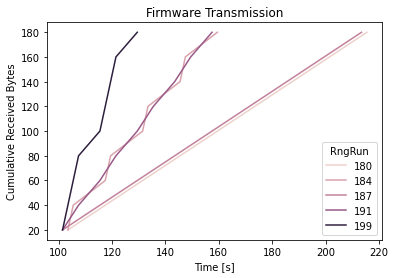

In [11]:
%matplotlib inline
sns.lineplot(data=results[results['ED'] == 0],
            x='Time [s]',
            y='Cumulative Received Bytes',
            hue='RngRun')
plt.title("Firmware Transmission")
plt.savefig('cumulative-bytes.pdf', bbox_inches='tight')
plt.show()

In [12]:
@sem.utils.yields_multiple_results
@sem.utils.output_labels(['Time [s]', 'ED'])
@sem.utils.only_load_some_files(['UpdateDownloadComplete'])
def get_update_complete_times(result):
    results = []
    for line in result['output']['UpdateDownloadComplete'].splitlines():
        time, ed = [float(i) for i in line.strip().split(" ")]
        results += [[time, ed]]
    return results

In [13]:
results = campaign.get_results_as_dataframe(get_update_complete_times)
display(results)

,nGateways,nDevices,radius,RngRun,Time [s],ED
0,2,100,20000,105,159.4828,51.0
1,2,100,20000,105,159.4828,95.0
2,2,100,20000,105,159.4828,2.0
3,2,100,20000,105,159.4828,71.0
4,2,100,20000,105,159.4828,74.0
...,...,...,...,...,...,...
7558,2,300,20000,2,2497.4830,177.0
7559,2,300,20000,2,59741.4800,91.0
7560,2,300,20000,2,72019.4800,143.0
7561,2,300,20000,2,108433.5000,90.0


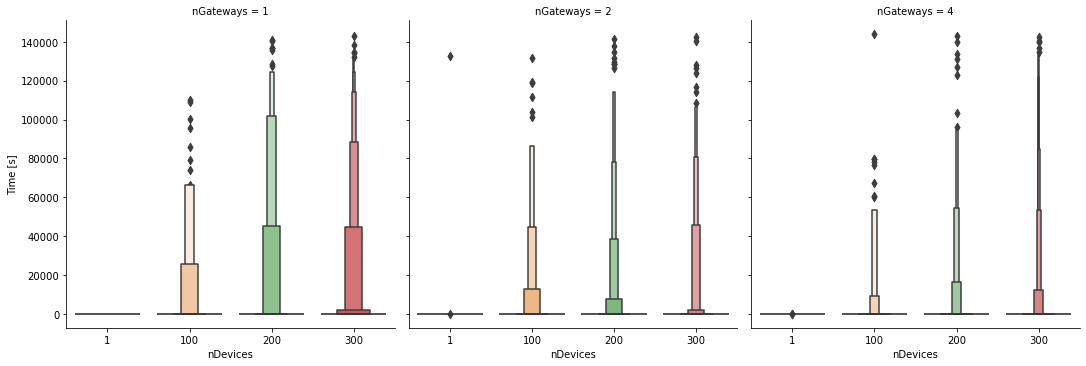

In [14]:
%matplotlib inline
sns.catplot(data=results,
            x='nDevices',
            y='Time [s]',
            col='nGateways',
            kind='boxen')
plt.show()

In [15]:
%matplotlib widget
sns.displot(data=results[results['nDevices']==300],
            x='Time [s]',
            hue='nGateways',
            kind='ecdf')
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …